In [16]:
#Import libraries
from __future__ import print_function
import time
import mxnet as mx
from mxnet import gluon
from mxnet.gluon import nn
from mxnet import autograd as ag
from tqdm import tqdm, tqdm_notebook
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [17]:
def gpu_exists():
    try:
        mx.nd.zeros((1,), ctx=mx.gpu(0))
    except:
        return False
    return True

data_ctx = mx.cpu()
if gpu_exists():
    print('Using GPU for model_ctx')
    model_ctx = mx.gpu(0)
else:
    print('Using CPU for model_ctx')
    model_ctx = mx.cpu()

Using CPU for model_ctx


# Dataset

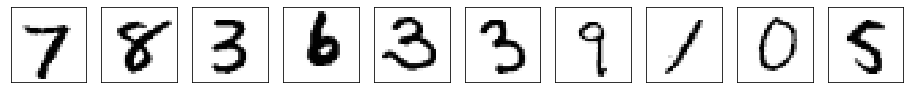

In [18]:
# Fixing the random seed
mx.random.seed(42)

# Gettin the mnist dataset
mnist = mx.test_utils.get_mnist()

n_samples = 10
idx = np.random.choice(len(mnist['train_data']), n_samples)
_, axarr = plt.subplots(1, n_samples, figsize=(16,4))
for i,j in enumerate(idx):
    axarr[i].imshow(mnist['train_data'][j][0], cmap='Greys')
    #axarr[i].axis('off')
    axarr[i].get_xaxis().set_ticks([])
    axarr[i].get_yaxis().set_ticks([])
plt.show()


In [19]:
#setting batch size
batch_size = 100
# creating training and validation set
train_data = mx.io.NDArrayIter(mnist['train_data'], mnist['train_label'], batch_size, shuffle=True)
val_data = mx.io.NDArrayIter(mnist['test_data'], mnist['test_label'], batch_size)

# Autoencoder Model

In [20]:
import mxnet.ndarray as F

class Autoencoder(gluon.Block):
    def __init__(self, input_size = 28*28, latent = 10, **kwargs):
        super(Autoencoder, self).__init__(**kwargs)
        with self.name_scope():
            self.encoder = nn.Sequential() 
            self.encoder.add(nn.Dense(512, activation='relu'))
            self.encoder.add(nn.Dense(128, activation='relu'))
            self.encoder.add(nn.Dense(latent, activation=None))
        
            self.decoder = nn.Sequential()
            self.decoder.add(nn.Dense(128, activation='relu'))
            self.decoder.add(nn.Dense(512, activation='relu'))
            self.decoder.add(nn.Dense( input_size, activation='sigmoid'))
    
    def forward(self, x):
        return self.decoder(self.encoder(x))

In [21]:
# call the model
net = Autoencoder()

In [22]:
# initalise network weights
net.initialize(mx.init.Xavier(magnitude=2.24), ctx=model_ctx)
# set optimization algorithm and learning rate
trainer = gluon.Trainer(net.collect_params(), 'adam', {'learning_rate': 0.02})

# Train

In [27]:
n_epoch = 10
mse_loss = gluon.loss.L2Loss()
start = time.time()
training_loss = []
validation_loss = []
for epoch in tqdm_notebook(range(n_epoch), desc='epochs'):
    epoch_loss = 0
    epoch_val_loss = 0

    train_data.reset()
    val_data.reset()

    n_batch_train = 0
    for batch in train_data:
        n_batch_train +=1
        data = batch.data[0].as_in_context(model_ctx)
        with ag.record():
            y = net(data)
            print(batch)
            loss = mse_loss(y,batch)
        loss.backward()
        trainer.step(data.shape[0])
        epoch_loss += nd.mean(loss).asscalar()

    n_batch_val = 0
    for batch in val_data:
        n_batch_val +=1
        data = batch.data[0].as_in_context(model_ctx)
        loss = net(data)
        epoch_val_loss += nd.mean(loss).asscalar()

    epoch_loss /= n_batch_train
    epoch_val_loss /= n_batch_val

    training_loss.append(epoch_loss)
    validation_loss.append(epoch_val_loss)


    tqdm.write('Epoch{}, Training loss {:.2f}, Validation loss {:.2f}'.format(epoch, epoch_loss, epoch_val_loss))

end = time.time()
print('Time elapsed: {:.2f}s'.format(end - start))

DataBatch: data shapes: [(100, 1, 28, 28)] label shapes: [(100,)]


AttributeError: 'DataBatch' object has no attribute 'reshape'

# Test and Recontruct Images

In [ ]:
val_data.reset()
test_batch = val_data.next()
net2(test_batch.data[0].as_in_context(model_ctx))
result = net.output.asnumpy()
original = test_batch.data[0].asnumpy()

# Visualize

In [ ]:
:
n_samples = 10
idx = np.random.choice(batch_size, n_samples)
_, axarr = plt.subplots(2, n_samples, figsize=(16,4))
for i,j in enumerate(idx):
    axarr[0,i].imshow(original[j].reshape((28,28)), cmap='Greys')
    if i==0:
        axarr[0,i].set_title('original')
    #axarr[0,i].axis('off')
    axarr[0,i].get_xaxis().set_ticks([])
    axarr[0,i].get_yaxis().set_ticks([])

    axarr[1,i].imshow(result[j].reshape((28,28)), cmap='Greys')
    if i==0:
        axarr[1,i].set_title('reconstruction')
    #axarr[1,i].axis('off')
    axarr[1,i].get_xaxis().set_ticks([])
    axarr[1,i].get_yaxis().set_ticks([])
plt.show()